## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [3]:
!pip install keras
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
You are using pip version 19.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [27]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(y_true, y_pred):
    """Define the customized loss."""    


    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        gamma = float(2.)
        alpha = float(4.)

        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)

    

    combined_loss = (1-ce_w) * K.categorical_crossentropy(y_pred,y_true)
    combined_loss += ce_w * focal_loss_fixed(y_true, y_pred)    
    return combined_loss
    
    

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [30]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss, metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_27 (

50000/50000 [==============================] - 2s 46us/step - loss: 5.7698 - accuracy: 0.6659 - val_loss: 8.1039 - val_accuracy: 0.4900
Epoch 12/25
50000/50000 [==============================] - 2s 46us/step - loss: 5.5453 - accuracy: 0.6807 - val_loss: 7.9533 - val_accuracy: 0.4963
Epoch 13/25
50000/50000 [==============================] - 2s 46us/step - loss: 5.2893 - accuracy: 0.6997 - val_loss: 8.0177 - val_accuracy: 0.4934
Epoch 14/25
50000/50000 [==============================] - 2s 46us/step - loss: 5.0576 - accuracy: 0.7159 - val_loss: 8.2107 - val_accuracy: 0.4808
Epoch 15/25
50000/50000 [==============================] - 2s 46us/step - loss: 4.8580 - accuracy: 0.7296 - val_loss: 8.3329 - val_accuracy: 0.4783
Epoch 16/25
50000/50000 [==============================] - 2s 46us/step - loss: 4.6552 - accuracy: 0.7431 - val_loss: 8.1356 - val_accuracy: 0.4891
Epoch 17/25
50000/50000 [==============================] - 2s 46us/step - loss: 4.4201 - accuracy: 0.7591 - val_loss: 8.1942

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 60us/step - loss: 8.0167 - accuracy: 0.3320 - val_loss: 8.8346 - val_accuracy: 0.2002
Epoch 2/25
50000/50000 [==============================] - 2s 48us/step - loss: 6.4817 - accuracy: 0.4497 - val_loss: 7.6328 - val_accuracy: 0.3465
Epoch 3/25
50000/50000 [==============================] - 2s 49us/step - loss: 6.0182 - accuracy: 0.4887 - val_loss: 7.0581 - val_accuracy: 0.4042
Epoch 4/25
50000/50000 [==============================] - 2s 49us/step - loss: 5.6910 - accuracy: 0.5189 - val_loss: 6.4432 - val_accuracy: 0.4585
Epoch 5/25
50000/50000 [==============================] - 2s 48us/step - loss: 5.4306 - accuracy: 0.5419 - val_loss: 6.2747 - val_accuracy: 0.4638
Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 5.1880 - accuracy: 0.5640 - val_loss: 6.0730 - val_accuracy: 0.4755
Epoch 7/25
50000/50000 [==============================] - 2s 49us/st

Epoch 21/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4059 - accuracy: 0.7692 - val_loss: 4.3930 - val_accuracy: 0.4805
Epoch 22/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3175 - accuracy: 0.7804 - val_loss: 4.4266 - val_accuracy: 0.4829
Epoch 23/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2210 - accuracy: 0.7951 - val_loss: 4.4365 - val_accuracy: 0.4852
Epoch 24/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1270 - accuracy: 0.8069 - val_loss: 4.7007 - val_accuracy: 0.4684
Epoch 25/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.0544 - accuracy: 0.8188 - val_loss: 4.7057 - val_accuracy: 0.4873


  Using cached https://files.pythonhosted.org/packages/4e/11/06958a2b895a3853206dea1fb2a5b11bf044f626f90745987612af9c8f2c/matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5d/bc/1e58593167fade7b544bfe9502a26dc860940a79ab306e651e7f13be68c2/pyparsing-2.4.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
You are using pip version 19.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


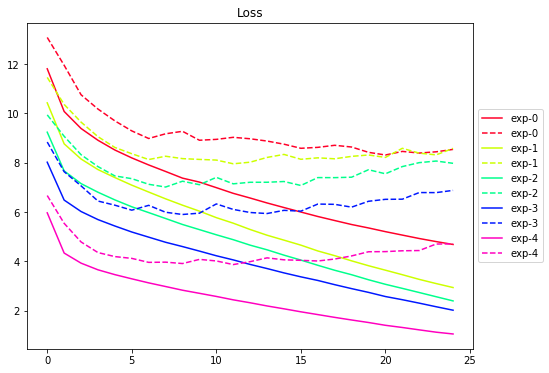

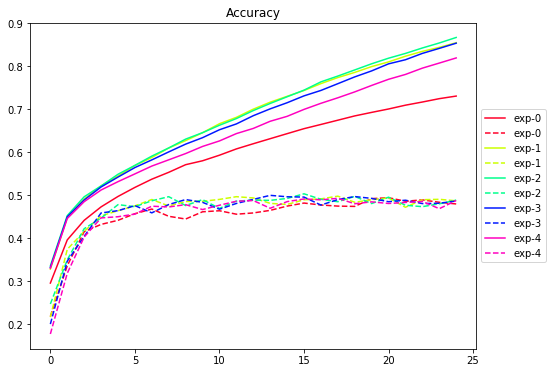

In [32]:
!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()